# GTHA housing market database
# OSEMN methodology Step 4: Model
# Classify land use from new features in Teranet (3 classes)
# Top 11 selected features

Top 11 selected features and with missing past/future xy sales filled with mean future/past xy sales.

---

This notebook describes _Step 4: Model_ of OSEMN methodology performed on the Teranet dataset.

## Import dependencies

In [1]:
random_state = 1

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer, LabelEncoder
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
# from pydotplus import graph_from_dot_data
from time import time

sns.set()

In [3]:
import sys

sys.path.append('../../../../src')

from io_utils import df_from_csv
from plot_utils import plot_hist
from model_utils import fit_model, targets_corr, plot_learning_curve, plot_validation_curve

In [4]:
def plot_pred_dif(df, y_col, y_pred_col, model_name='model', feat_set_name='', set_name='', labels=None):
    
    pred_dif = df[y_col].value_counts().sort_index() - df[y_pred_col].value_counts()

    mask1 = df[y_col] != df[y_pred_col]
    print("{0:,} misclassified entries in the subset, or {1:.2f}% of the total {2:,}.".format(len(df[mask1]), 
                                                                                              len(df[mask1]) / len(s) * 100,
                                                                                              len(df)))
    pred_dif.plot(kind='barh')
    if labels is not None:
        plt.yticks(ticks=[0, 1, 2, 3], labels=labels)
    plt.title("{0},\n'{1}' feature set, {2}\ncount difference (real-predicted), by class"
              .format(model_name, feat_set_name, set_name))
    plt.grid(axis='y')
    plt.show()

## Load Teranet data

In [5]:
data_path = '../../../../data/'
teranet_path = data_path + 'teranet/'
os.listdir(teranet_path)

['1.1_Teranet_DA.csv',
 '1.3_Teranet_DA_TAZ_PG_FSA.csv',
 '4_Teranet_lu_predict_3c.csv',
 '2_Teranet_consistent.csv',
 'parcel16_epoi13.csv',
 '1.2_Teranet_DA_TAZ.csv',
 '1.4_Teranet_DA_TAZ_FSA_LU_LUDMTI.csv',
 '1.4_Teranet_DA_TAZ_FSA_LU.csv',
 '4_Teranet_lu_predict_4c.csv',
 '.ipynb_checkpoints',
 'ParcelLandUse.zip',
 'ParcelLandUse',
 'HHSaleHistory.csv',
 '3_Teranet_nonan_new_cols.csv',
 'GTAjoinedLanduseSales']

In [6]:
teranet_df = df_from_csv(teranet_path + '4_Teranet_lu_predict_3c.csv', parse_dates=['registration_date'])

----- DataFrame loaded
in 118.03 seconds
with 5,188,513 rows
and 79 columns
-- Column names:
 Index(['transaction_id', 'lro_num', 'pin', 'consideration_amt',
       'registration_date', 'postal_code', 'unitno', 'street_name',
       'street_designation', 'street_direction', 'municipality',
       'street_number', 'x', 'y', 'dauid', 'csduid', 'csdname', 'taz_o', 'fsa',
       'pca_id', 'postal_code_dmti', 'pin_lu', 'landuse', 'prop_code',
       'dmti_lu', 'street_name_raw', 'year', 'year_month', 'year3',
       'census_year', 'census2001_year', 'tts_year', 'tts1991_year', 'xy',
       'pin_total_sales', 'xy_total_sales', 'pin_prev_sales', 'xy_prev_sales',
       'xy_first_sale', 'pin_years_since_last_sale',
       'xy_years_since_last_sale', 'xy_years_to_next_sale',
       'da_days_since_last_sale', 'da_years_since_last_sale',
       'xy_sale_next_6m', 'price_2016', 'pin_price_cum_sum',
       'xy_price_cum_sum', 'pin_price_pct_change', 'xy_price_pct_change',
       'price_da_pct_chang

## Load Census data

In [7]:
census_path = data_path + 'census/'
os.listdir(census_path)

['da_census_income.csv',
 'Census data availability.xlsx',
 'da_census.xls',
 'da_census_select_tidy.csv',
 'da_census_income_shapefile',
 'da_census_select.csv']

In [8]:
census_df = df_from_csv(census_path + 'da_census_select_tidy.csv')

----- DataFrame loaded
in 0.16 seconds
with 36,728 rows
and 32 columns
-- Column names:
 Index(['DAUID', 'year', 'Avg_HHsize', 'Avg_HHinc', 'Avg_own_payt',
       'Avg_val_dwel', 'Avg_rent', 'Pop', 'PopDens', 'Dwel', 'DwelDens',
       'Sgl_det', 'Apt_5plus', 'Sgl_att', 'Owned', 'Rented', 'CarTrVan_d',
       'CarTrVan_p', 'PT', 'Walk', 'Bike', 'Lbrfrc', 'Emp', 'Unemp',
       'Not_lbrfrc', 'Employee', 'Self_emp', 'At_home', 'No_fix_wkpl',
       'Usl_wkpl', 'Blue_cljob', 'White_cljob'],
      dtype='object')


## Load TTS data

In [9]:
tts_path = data_path + 'tts/'
os.listdir(tts_path)

['tts_num_jobs_tidy.csv',
 'TAZ_2001shp.zip',
 'TAZ_2001shp',
 'taz_tts_tidy.csv',
 'taz_info.csv',
 'TTS_variables.xlsx',
 'taz_tts.xlsx',
 'Num_of_Jobs.xlsx']

In [10]:
tts_df = df_from_csv(tts_path + 'taz_tts_tidy.csv')

----- DataFrame loaded
in 0.01 seconds
with 12,012 rows
and 8 columns
-- Column names:
 Index(['TAZ_O', 'year', 'Pop', 'FT_wrk', 'Stu', 'HH', 'Jobs', 'Cars'], dtype='object')


## Join Census data to Teranet data

In [11]:
t = time()
df = pd.merge(teranet_df, census_df, how='left',
              left_on=['dauid', 'census2001_year'], right_on=['DAUID', 'year'])
df = df.drop(['DAUID', 'year_y'], axis=1).rename(columns={'year_x': 'year'})
elapsed = time() - t
print("----- Census variables were joined to the DataFrame"
      "\nin {0:,.2f} seconds ({1:.2f} minutes)".format(elapsed, elapsed / 60) + 
      "\nwith {0:,} rows\nand {1:,} columns"
      .format(df.shape[0], df.shape[1]) + 
      "\n-- Column names:\n", df.columns)

----- Census variables were joined to the DataFrame
in 47.49 seconds (0.79 minutes)
with 5,188,513 rows
and 109 columns
-- Column names:
 Index(['transaction_id', 'lro_num', 'pin', 'consideration_amt',
       'registration_date', 'postal_code', 'unitno', 'street_name',
       'street_designation', 'street_direction',
       ...
       'Emp', 'Unemp', 'Not_lbrfrc', 'Employee', 'Self_emp', 'At_home',
       'No_fix_wkpl', 'Usl_wkpl', 'Blue_cljob', 'White_cljob'],
      dtype='object', length=109)


## Join TTS data to Teranet data

In [12]:
t = time()
df = pd.merge(df, tts_df, how='left',
              left_on=['taz_o', 'tts_year'], right_on=['TAZ_O', 'year'])
df = df.drop(['taz_o', 'year_y'], axis=1).rename(columns={'year_x': 'year'})
elapsed = time() - t
print("----- TTS variables were joined to the DataFrame"
      "\nin {0:,.2f} seconds ({1:.2f} minutes)".format(elapsed, elapsed / 60) + 
      "\nwith {0:,} rows\nand {1:,} columns"
      .format(df.shape[0], df.shape[1]) + 
      "\n-- Column names:\n", df.columns)

----- TTS variables were joined to the DataFrame
in 50.49 seconds (0.84 minutes)
with 5,188,513 rows
and 115 columns
-- Column names:
 Index(['transaction_id', 'lro_num', 'pin', 'consideration_amt',
       'registration_date', 'postal_code', 'unitno', 'street_name',
       'street_designation', 'street_direction',
       ...
       'Usl_wkpl', 'Blue_cljob', 'White_cljob', 'TAZ_O', 'Pop_y', 'FT_wrk',
       'Stu', 'HH', 'Jobs', 'Cars'],
      dtype='object', length=115)


## Take a train-test subset of Teranet records

In [14]:
year_train_test_min = 2011
year_train_test_max = 2014
year_val1 = 2010
year_val2 = 2015

s = df.query('year >= @year_train_test_min & year <= @year_train_test_max')
s_val1 = df.query('year == @year_val1')
s_val2 = df.query('year == @year_val2')

print("{0:,} Teranet records in the train-test subset (records from {1} to {2})."
      .format(len(s), year_train_test_min, year_train_test_max))
print("{0:,} Teranet records in the validation subset #1 (records from {1}).".format(len(s_val1), year_val1))
print("{0:,} Teranet records in the validation subset #2 (records from {1}).".format(len(s_val2), year_val2))

857,896 Teranet records in the train-test subset (records from 2011 to 2014).
216,492 Teranet records in the validation subset #1 (records from 2010).
244,787 Teranet records in the validation subset #2 (records from 2015).


## Select features

In [15]:
s.columns

Index(['transaction_id', 'lro_num', 'pin', 'consideration_amt',
       'registration_date', 'postal_code', 'unitno', 'street_name',
       'street_designation', 'street_direction',
       ...
       'Usl_wkpl', 'Blue_cljob', 'White_cljob', 'TAZ_O', 'Pop_y', 'FT_wrk',
       'Stu', 'HH', 'Jobs', 'Cars'],
      dtype='object', length=115)

In [16]:
top11f = ['xy_total_sales', 'xy_prev_sales', 'xy_first_sale',
          'xy_years_since_last_sale', 'xy_years_to_next_sale', 'med_price_xy',
          'Avg_HHsize', 'Avg_rent', 'PopDens', 'DwelDens', 'Apt_5plus',
          'lucr']
s = s[top11f]
s_val1 = s_val1[top11f]
s_val2 = s_val2[top11f]
s.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 857896 entries, 0 to 5002104
Data columns (total 12 columns):
xy_total_sales              857896 non-null int64
xy_prev_sales               857896 non-null int64
xy_first_sale               857896 non-null bool
xy_years_since_last_sale    746796 non-null float64
xy_years_to_next_sale       575944 non-null float64
med_price_xy                857896 non-null float64
Avg_HHsize                  855523 non-null float64
Avg_rent                    855435 non-null float64
PopDens                     857896 non-null float64
DwelDens                    857896 non-null float64
Apt_5plus                   855523 non-null float64
lucr                        857896 non-null object
dtypes: bool(1), float64(8), int64(2), object(1)
memory usage: 79.4+ MB


## Fill missing values

In [17]:
col1 = 'xy_years_to_next_sale'
col2 = 'xy_years_since_last_sale'
mask1 = s[col1].isnull()
print("For records with missing '{0}', values of '{1}' are: mean={2:,.2f}, median={3:,.2f}"
      .format(col1, col2, s.loc[mask1, col2].mean(), s.loc[mask1, col2].median()))
mask1 = s[col2].isnull()
print("For records with missing '{0}', values of '{1}' are: mean={2:,.2f}, median={3:,.2f}"
      .format(col2, col1, s.loc[mask1, col1].mean(), s.loc[mask1, col1].median()))

For records with missing 'xy_years_to_next_sale', values of 'xy_years_since_last_sale' are: mean=7.72, median=6.02
For records with missing 'xy_years_since_last_sale', values of 'xy_years_to_next_sale' are: mean=2.02, median=1.69


In [18]:
# missing year to next sale is replaced with median year since last sale and vice versa
mask1 = s[col1].isnull()
s.loc[mask1, col1] = s.loc[mask1, col2].median()
mask1 = s_val1[col1].isnull()
s_val1.loc[mask1, col1] = s_val1.loc[mask1, col2].median()
mask1 = s_val2[col1].isnull()
s_val2.loc[mask1, col1] = s_val2.loc[mask1, col2].median()

mask1 = s[col2].isnull()
s.loc[mask1, col2] = s.loc[mask1, col1].median()
mask1 = s_val1[col2].isnull()
s_val1.loc[mask1, col2] = s_val1.loc[mask1, col1].median()
mask1 = s_val2[col2].isnull()
s_val2.loc[mask1, col2] = s_val2.loc[mask1, col1].median()

s.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 857896 entries, 0 to 5002104
Data columns (total 12 columns):
xy_total_sales              857896 non-null int64
xy_prev_sales               857896 non-null int64
xy_first_sale               857896 non-null bool
xy_years_since_last_sale    857896 non-null float64
xy_years_to_next_sale       857896 non-null float64
med_price_xy                857896 non-null float64
Avg_HHsize                  855523 non-null float64
Avg_rent                    855435 non-null float64
PopDens                     857896 non-null float64
DwelDens                    857896 non-null float64
Apt_5plus                   855523 non-null float64
lucr                        857896 non-null object
dtypes: bool(1), float64(8), int64(2), object(1)
memory usage: 79.4+ MB


In [19]:
s = s.dropna()
s_val1 = s_val1.dropna()
s_val2 = s_val2.dropna()
print("{0:,} rows in train-test subset, {1:,} rows in validation subset #1, {2:,} rows in validation subset #2"
      .format(len(s), len(s_val1), len(s_val2)))

855,378 rows in train-test subset, 216,155 rows in validation subset #1, 244,425 rows in validation subset #2


In [20]:
target_cols = 4
feat_cols = s.columns[:-target_cols]
feat_cols

Index(['xy_total_sales', 'xy_prev_sales', 'xy_first_sale',
       'xy_years_since_last_sale', 'xy_years_to_next_sale', 'med_price_xy',
       'Avg_HHsize', 'Avg_rent'],
      dtype='object')

In [21]:
feat_set_name = 'top11f_3c'

## Encode target

In [22]:
le = LabelEncoder()

s['lucr_e'] = le.fit_transform(s['lucr'])
s_val1['lucr_e'] = le.transform(s_val1['lucr'])
s_val2['lucr_e'] = le.transform(s_val2['lucr'])

print(s['lucr'].value_counts().sort_index())
print(s['lucr_e'].value_counts().sort_index())
print(s_val1['lucr'].value_counts().sort_index())
print(s_val1['lucr_e'].value_counts().sort_index())
print(s_val2['lucr'].value_counts().sort_index())
print(s_val2['lucr_e'].value_counts().sort_index())

s = s.drop(['lucr'], axis=1)
s_val1 = s_val1.drop(['lucr'], axis=1)
s_val2 = s_val2.drop(['lucr'], axis=1)
print("Land use encoded!")

condo    222904
house    288879
other    343595
Name: lucr, dtype: int64
0    222904
1    288879
2    343595
Name: lucr_e, dtype: int64
condo    66944
house    77497
other    71714
Name: lucr, dtype: int64
0    66944
1    77497
2    71714
Name: lucr_e, dtype: int64
condo     57424
house     76798
other    110203
Name: lucr, dtype: int64
0     57424
1     76798
2    110203
Name: lucr_e, dtype: int64
Land use encoded!


## Prepare features

#### Select features and target

In [23]:
X = s[feat_cols].values
X_val1 = s_val1[feat_cols].values
X_val2 = s_val2[feat_cols].values
y = s['lucr_e'].values
y_val1 = s_val1['lucr_e'].values
y_val2 = s_val2['lucr_e'].values
print("Features and target selected.")

Features and target selected.


#### Perform the train-test split

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state, stratify=y)
print("Performed train-test split.")
print('Labels counts in y:', np.bincount(y))
print('Labels counts in y_train:', np.bincount(y_train))
print('Labels counts in y_test:', np.bincount(y_test))
print('Labels counts in y_val1:', np.bincount(y_val1))
print('Labels counts in y_val2:', np.bincount(y_val2))

Performed train-test split.
Labels counts in y: [222904 288879 343595]
Labels counts in y_train: [156033 202215 240516]
Labels counts in y_test: [ 66871  86664 103079]
Labels counts in y_val1: [66944 77497 71714]
Labels counts in y_val2: [ 57424  76798 110203]


#### Standardize features

In [25]:
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)
X_val1_std = sc.transform(X_val1)
X_val2_std = sc.transform(X_val2)
print("Input features were standardized.")

Input features were standardized.


#### Normalize features

In [26]:
sc = MinMaxScaler()
sc.fit(X_train)
X_train_norm = sc.transform(X_train)
X_test_norm = sc.transform(X_test)
X_val1_norm = sc.transform(X_val1)
X_val2_norm = sc.transform(X_val2)
print("Input features were normalized.")

Input features were normalized.


#### Apply power transormation to the features

In [39]:
sc = PowerTransformer(method='yeo-johnson')
sc.fit(X_train)
X_train_pt = sc.transform(X_train)
X_test_pt = sc.transform(X_test)
X_val1_pt = sc.transform(X_val1)
X_val2_pt = sc.transform(X_val2)
print("Power transformation was applied to the features.")

/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/sklearn/preprocessing/data.py:2863: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


Power transformation was applied to the features.


### Train and test classification algorithms

In [27]:
#from sklearn.model_selection import GridSearchCV
#from sklearn.model_selection import cross_val_score

#param_grid = [{'max_depth': [1, 2, 3, 4, 5, 6, 7, None]}]

#gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state=random_state),
#                  param_grid=param_grid, scoring='accuracy', cv=2, n_jobs=8)

#scores = cross_val_score(gs, X_train, y_train, scoring='accuracy', cv=5)
#print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

In [28]:
scores_df = pd.DataFrame(columns=['train', 'test', 'val1', 'val2'])

#### Perceptron learning algorithm

Validation curve for Perceptron plotted, took 447.26 seconds (7.45 minutes)


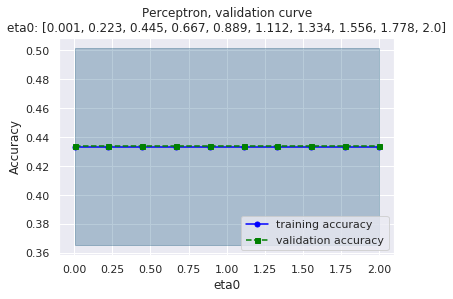

In [29]:
param_name = 'eta0'
param_range = np.round(np.linspace(0.001, 2, 10), 3)
model_name = "Perceptron"
ppn = Perceptron(random_state=random_state)
plot_validation_curve(ppn, model_name, X_train, y_train, param_name, param_range, n_jobs=12)

Validation curve for Perceptron (normalized) plotted, took 178.33 seconds (2.97 minutes)


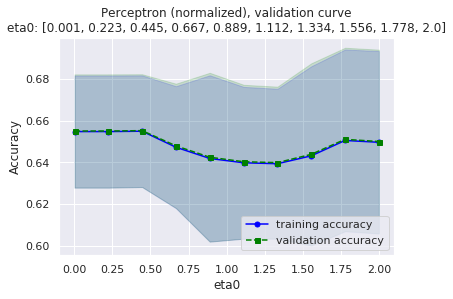

In [30]:
param_name = 'eta0'
param_range = np.round(np.linspace(0.001, 2, 10), 3)
model_name = "Perceptron (normalized)"
ppn = Perceptron(random_state=random_state)
plot_validation_curve(ppn, model_name, X_train_norm, y_train, param_name, param_range, n_jobs=12)

Validation curve for Perceptron (standardized) plotted, took 204.35 seconds (3.41 minutes)


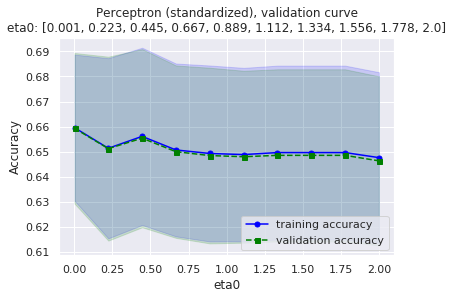

In [31]:
param_name = 'eta0'
param_range = np.round(np.linspace(0.001, 2, 10), 3)
model_name = "Perceptron (standardized)"
ppn = Perceptron(random_state=random_state)
plot_validation_curve(ppn, model_name, X_train_std, y_train, param_name, param_range, n_jobs=12)

Validation curve for Perceptron (power transform) plotted, took 255.36 seconds (4.26 minutes)


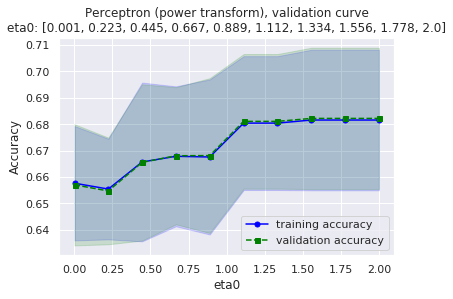

In [40]:
param_name = 'eta0'
param_range = np.round(np.linspace(0.001, 2, 10), 3)
model_name = "Perceptron (power transform)"
ppn = Perceptron(random_state=random_state)
plot_validation_curve(ppn, model_name, X_train_pt, y_train, param_name, param_range, n_jobs=12)

##### Best model performance

In [32]:
model_name = 'Perceptron (normalized features)'
eta = 0.22
max_iter = 7
scores_name = 'ppn_norm_eta{0}_maxiter{1}'.format(eta, max_iter)
ppn = Perceptron(max_iter=max_iter, eta0=eta, random_state=1)
scores_df.loc[scores_name] = \
    fit_model(ppn, model_name, X_train_norm, y_train, X_test_norm, y_test, X_val1_norm, y_val1, X_val2_norm, y_val2,
              return_scores=True)


Perceptron (normalized features) fit, took 2.05 seconds (0.03 minutes)
accuracy: train=0.63, test=0.63, validation #1=0.68, validation #2=0.61


#### Logistic regression

#### L2

Validation curve for Logistic regression (L2) plotted, took 1,072.83 seconds (17.88 minutes)


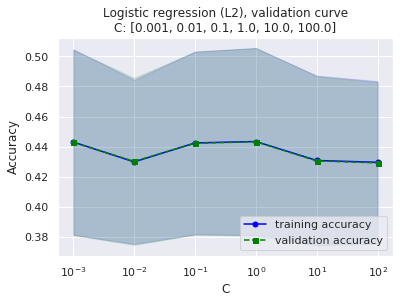

In [33]:
param_name = 'C'
param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
model_name = "Logistic regression (L2)"
lr = LogisticRegression(penalty='l2', random_state=random_state, solver='lbfgs', multi_class='auto', n_jobs=12)
plot_validation_curve(lr, model_name, X_train, y_train, param_name, param_range, xlog=True)

Validation curve for Logistic regression (L2, normalized) plotted, took 1,075.31 seconds (17.92 minutes)


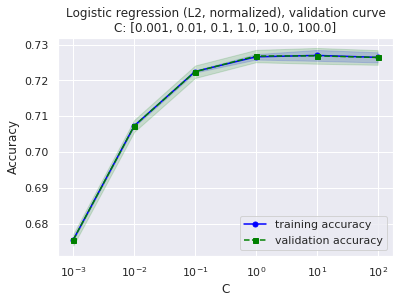

In [34]:
param_name = 'C'
param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
model_name = "Logistic regression (L2, normalized)"
lr = LogisticRegression(penalty='l2', random_state=random_state, solver='lbfgs', multi_class='auto', n_jobs=12)
plot_validation_curve(lr, model_name, X_train_norm, y_train, param_name, param_range, xlog=True)

Validation curve for Logistic regression (L2, standardized) plotted, took 1,140.41 seconds (19.01 minutes)


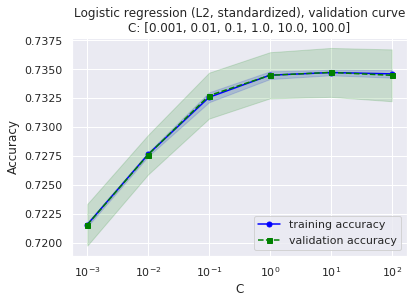

In [35]:
param_name = 'C'
param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
model_name = "Logistic regression (L2, standardized)"
lr = LogisticRegression(penalty='l2', random_state=random_state, solver='lbfgs', multi_class='auto', n_jobs=12)
plot_validation_curve(lr, model_name, X_train_std, y_train, param_name, param_range, xlog=True)

Validation curve for Logistic regression (L2, power transform) plotted, took 1,070.54 seconds (17.84 minutes)


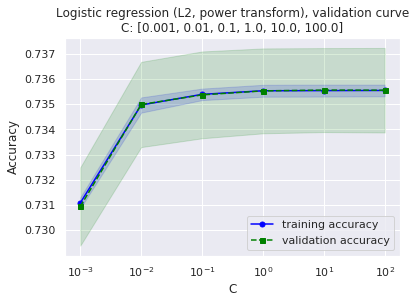

In [41]:
param_name = 'C'
param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
model_name = "Logistic regression (L2, power transform)"
lr = LogisticRegression(penalty='l2', random_state=random_state, solver='lbfgs', multi_class='auto', n_jobs=12)
plot_validation_curve(lr, model_name, X_train_pt, y_train, param_name, param_range, xlog=True)

#### L1

In [36]:
param_name = 'C'
param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
model_name = "Logistic regression (L1, normalized)"
lr = LogisticRegression(penalty='l1', random_state=1, solver='liblinear', multi_class='auto')
plot_validation_curve(lr, model_name, X_train_norm, y_train, param_name, param_range, xlog=True, n_jobs=8)

/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


KeyboardInterrupt: 

##### Best model performance

In [52]:
model_name = 'Logistic regression (L2, standardized features)'
c = 1.0
max_iter = 150
scores_name = 'lr_l2_std_c{0}_maxiter{1}'.format(c, max_iter)

lr = LogisticRegression(C=c, random_state=random_state, solver='lbfgs', multi_class='auto', max_iter=max_iter, n_jobs=12)
scores_df.loc[scores_name] = \
    fit_model(lr, model_name, X_train_std, y_train, X_test_std, y_test, X_val1_std, y_val1, X_val2_std, y_val2,
              return_scores=True, verbose=False)

lr = LogisticRegression(C=c, random_state=random_state, solver='lbfgs', multi_class='auto', max_iter=max_iter, n_jobs=12)
lr_coef = fit_model(lr, model_name, X_train_std, y_train, X_test_std, y_test, X_val1_std, y_val1, X_val2_std, y_val2,
          return_coefs=True, feat_names=feat_cols, class_names=le.classes_)


Logistic regression (L2, standardized features) fit, took 34.51 seconds (0.58 minutes)
accuracy: train=0.73, test=0.73, validation #1=0.74, validation #2=0.74


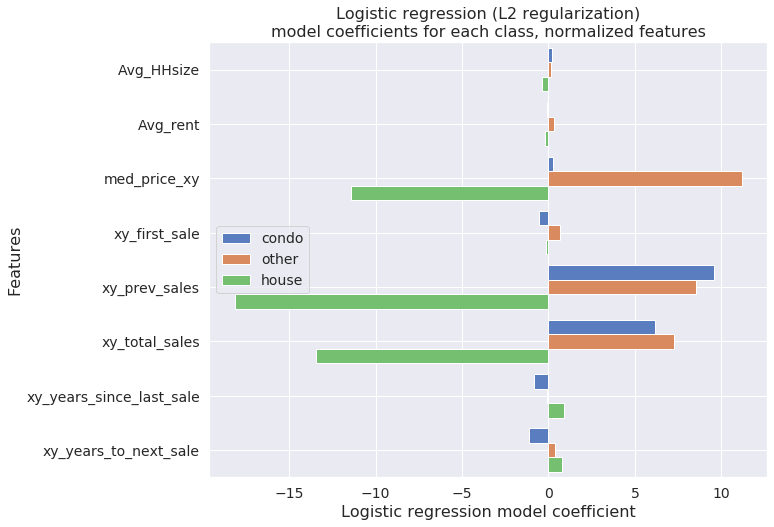

In [53]:
f, ax = plt.subplots(1, figsize=(10, 8))
sns.barplot(x="coefficient", y="var", hue="class", data=lr_coef.sort_values('var'), palette="muted", ax=ax)
ax.set_ylabel("Features", fontsize=16)
ax.set_xlabel("Logistic regression model coefficient", fontsize=16)
ax.set_title("Logistic regression (L2 regularization)\nmodel coefficients for each class, normalized features", 
             fontsize=16)
ax.grid(True)
ax.legend(loc='center left', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('../../results/plots/{0}_{1}_feats_norm_coefs.png'
            .format(model_name, feat_set_name), dpi=300, bbox_inches='tight')

In [55]:
model_name = 'Logistic regression with L1 regularization (standardized features)'
c = 0.1
max_iter = 50
scores_name = 'lr_l1_std_c{0}_maxiter{1}'.format(c, max_iter)

lr = LogisticRegression(penalty='l1', C=c, random_state=1, solver='liblinear', multi_class='auto', max_iter=max_iter)
scores_df.loc[scores_name] = \
    fit_model(lr, model_name, X_train_std, y_train, X_test_std, y_test, X_val1_std, y_val1, X_val2_std, y_val2,
              return_scores=True, verbose=False)

lr = LogisticRegression(penalty='l1', C=c, random_state=1, solver='liblinear', multi_class='auto', max_iter=max_iter)
lr_coef = fit_model(lr, model_name, X_train_std, y_train, X_test_std, y_test, X_val1_std, y_val1, X_val2_std, y_val2,
          return_coefs=True, feat_names=feat_cols, class_names=le.classes_)

/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)



Logistic regression with L1 regularization (standardized features) fit, took 85.32 seconds (1.42 minutes)
accuracy: train=0.72, test=0.72, validation #1=0.72, validation #2=0.74


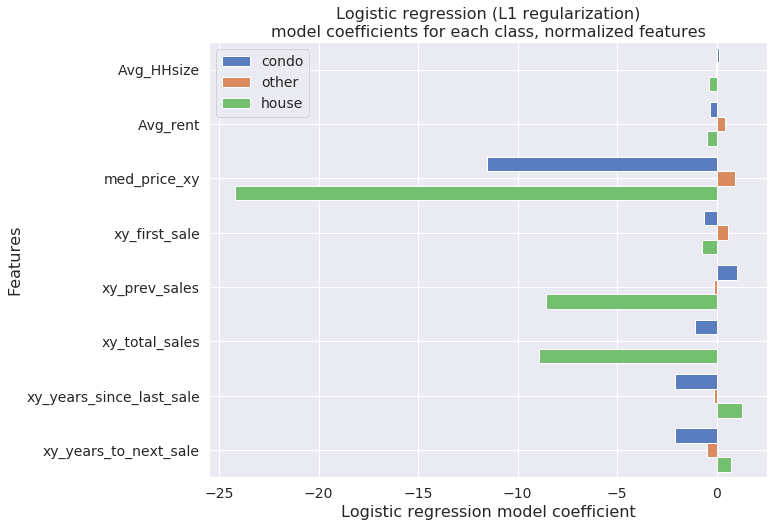

In [56]:
f, ax = plt.subplots(1, figsize=(10, 8))
sns.barplot(x="coefficient", y="var", hue="class", data=lr_coef.sort_values('var'), palette="muted", ax=ax)
ax.set_ylabel("Features", fontsize=16)
ax.set_xlabel("Logistic regression model coefficient", fontsize=16)
ax.set_title("Logistic regression (L1 regularization)\nmodel coefficients for each class, normalized features", 
             fontsize=16)
ax.grid(True)
ax.legend(loc='upper left', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('../../results/plots/{0}_{1}_feats_norm_coefs.png'
            .format(scores_name, feat_set_name), dpi=300, bbox_inches='tight')

#### Decision Tree

Validation curve for Decision Tree plotted, took 757.80 seconds (12.63 minutes)


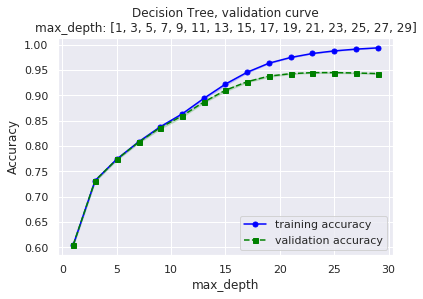

In [42]:
param_name = 'max_depth'
param_range = list(range(1, 30, 2))
model_name = "Decision Tree"
tree = DecisionTreeClassifier(criterion='gini',  random_state=random_state)
plot_validation_curve(tree, model_name, X_train, y_train, param_name, param_range)

##### Best model performance

In [58]:
# set model name and hyperparameters
max_depth = 23
criterion = 'gini'
model_name = 'Decision Tree ({0} criterion, raw features)'.format(criterion)
scores_name = 'tree_raw_{0}_{1}'.format(criterion, max_depth)

# get best model scores
tree = DecisionTreeClassifier(criterion=criterion, max_depth=max_depth, random_state=1)
scores_df.loc[scores_name] = \
    fit_model(tree, model_name, X_train, y_train, X_test, y_test, X_val1, y_val1, X_val2, y_val2,
              return_scores=True)

# visualize decision tree
tree = DecisionTreeClassifier(criterion=criterion, max_depth=max_depth, random_state=1)
tree.fit(X_train, y_train)
dot_data = export_graphviz(tree, filled=True, rounded=True, class_names=le.classes_,
                           feature_names=feat_cols, 
                           out_file='../../results/{0}_{1}_features.dot'.format(model_name, feat_set_name))

# graph = graph_from_dot_data(dot_data)
# graph.set('dpi', '500')
# graph.write_png('../../results/plots/tree_teranet_census_tts_4c.png')


Decision Tree (gini criterion, raw features) fit, took 6.66 seconds (0.11 minutes)
accuracy: train=0.98, test=0.95, validation #1=0.89, validation #2=0.84


#### Random Forest

Validation curve for Random Forest plotted, took 3,421.11 seconds (57.02 minutes)


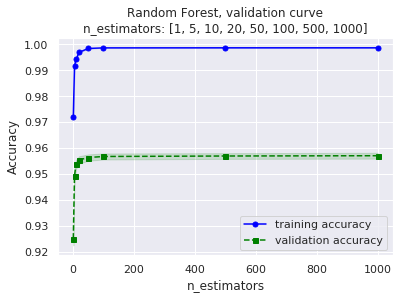

In [45]:
param_name = 'n_estimators'
param_range = [1, 5, 10, 20, 50, 100, 500, 1000]
model_name = "Random Forest"
forest = RandomForestClassifier(criterion='gini', random_state=random_state, n_jobs=12)
plot_validation_curve(forest, model_name, X_train, y_train, param_name, param_range)

##### Best model performance

In [46]:
# set model name and hyperparameters
n_trees = 16
criterion = 'gini'
scores_name = 'forest_raw_{0}_{1}'.format(criterion, n_trees)

# get best model scores
forest = RandomForestClassifier(criterion='gini', n_estimators=n_trees, random_state=1, n_jobs=12)
scores_df.loc[scores_name] = \
    fit_model(forest, model_name, X_train, y_train, X_test, y_test, X_val1, y_val1, X_val2, y_val2,
              return_scores=True)


Random Forest fit, took 8.13 seconds (0.14 minutes)
accuracy: train=1.00, test=0.96, validation #1=0.92, validation #2=0.86


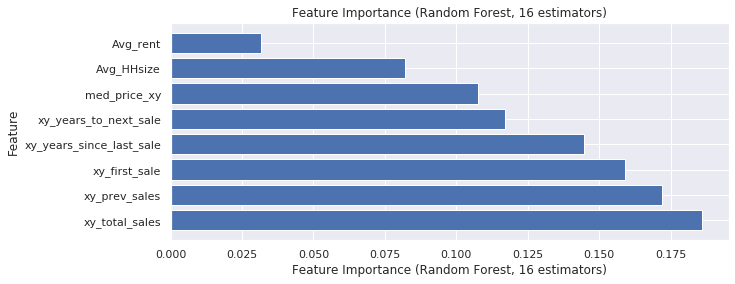

In [47]:
# fit Random Forest model
model_name = 'Random Forest (raw features, {0} estimators)'.format(n_trees)
forest = RandomForestClassifier(criterion='gini', n_estimators=n_trees, random_state=1, n_jobs=8)
forest.fit(X_train, y_train)
forest.score(X_val1, y_val1)

# plot feature importances from Random Forest
importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]

f, ax = plt.subplots(1, figsize=(10, 4))
ax.set_title('Feature Importance (Random Forest, {0} estimators)'.format(n_trees))
plt.barh(feat_cols, importances[indices], align='center')
ax.set_xlabel('Feature Importance (Random Forest, {0} estimators)'.format(n_trees))
ax.set_ylabel('Feature')
f.savefig('../../results/plots/rf{0}_'.format(n_trees) + feat_set_name + '_feature_importance.png', dpi=300)

#### K-nearest neighbors

##### Normalized features, Manhattan distance

In [ ]:
p = 1
param_name = 'n_neighbors'
param_range = list(range(1, 10))
model_name = "K-nearest neighbors (normalized  features)"
knn = KNeighborsClassifier(metric='minkowski', p=p, n_jobs=12)
plot_validation_curve(knn, model_name, X_train_norm, y_train, param_name, param_range)

##### Normalized features, Euclidean distance

In [ ]:
p = 2
param_name = 'n_neighbors'
param_range = list(range(1, 10))
model_name = "K-nearest neighbors (normalized  features)"
knn = KNeighborsClassifier(metric='minkowski', p=p, n_jobs=12)
plot_validation_curve(knn, model_name, X_train_norm, y_train, param_name, param_range)

##### Best model performance

In [59]:
k = 5
p = 1
model_name = 'K-nearest neighbors, k={0}, p={1} (normalized  features)'.format(k, p)
scores_name = 'knn_norm_k{0}_p{1}'.format(k, p)

knn = KNeighborsClassifier(n_neighbors=k, p=p, metric='minkowski')
scores_df.loc[scores_name] = \
    fit_model(knn, model_name, X_train_norm, y_train, X_test_norm, y_test, X_val1_norm, y_val1, X_val2_norm, y_val2,
              return_scores=True)


K-nearest neighbors, k=5, p=1 (normalized  features) fit, took 447.36 seconds (7.46 minutes)
accuracy: train=0.95, test=0.94, validation #1=0.88, validation #2=0.83


## Compare perfomance of models

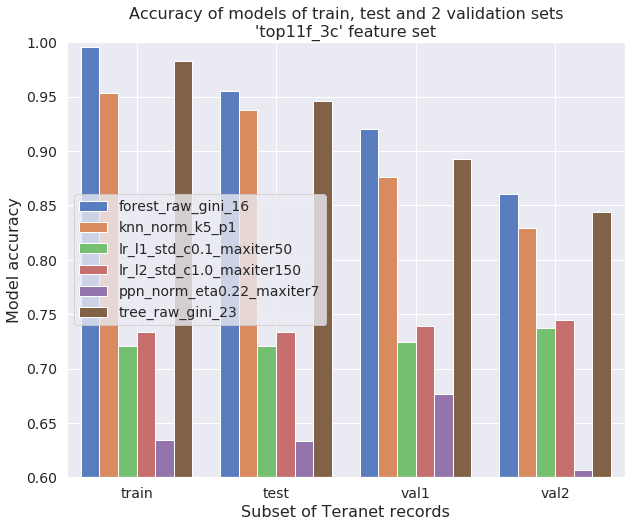

In [60]:
scores_tidy = scores_df.reset_index().rename(columns={'index': 'model'})\
                       .melt(id_vars='model', var_name='subset', value_name='score').sort_values(['model', 'subset'])

f, ax = plt.subplots(1, figsize=(10, 8))
sns.barplot(x="subset", y="score", hue="model", order=['train', 'test', 'val1', 'val2'],
                                                       data=scores_tidy, palette="muted", ax=ax)
ax.set_ylabel("Model accuracy", fontsize=16)
ax.set_xlabel("Subset of Teranet records", fontsize=16)
ax.set_title("Accuracy of models of train, test and 2 validation sets\n'{0}' feature set".format(feat_set_name), 
             fontsize=16)
ax.grid(True)
ax.legend(loc='center left', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax.set_ylim(0.6, 1.0)
plt.savefig('../../results/plots/model_performance_' + feat_set_name + '.png'
            .format(model_name), dpi=300, bbox_inches='tight')

## Learning curves

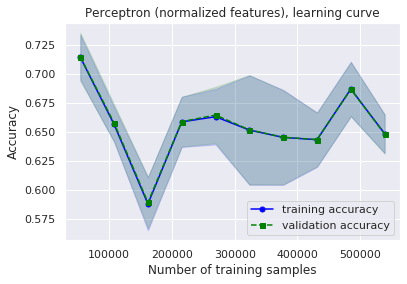

In [61]:
model_name = 'Perceptron (normalized features)'
eta = 0.22
max_iter = 7
ppn = Perceptron(max_iter=max_iter, eta0=eta, random_state=random_state)
plot_learning_curve(ppn, model_name, X_train_norm, y_train, n_jobs=12)

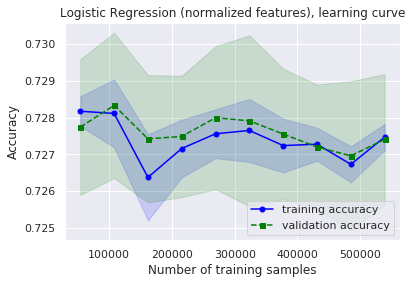

In [62]:
model_name = 'Logistic Regression (normalized features)'
lr = LogisticRegression(C=100.0, random_state=random_state, solver='lbfgs', multi_class='auto', max_iter=150, n_jobs=12)
plot_learning_curve(lr, model_name, X_train_norm, y_train)

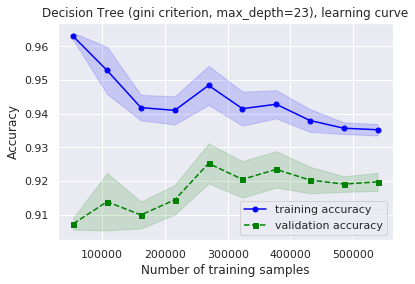

In [63]:
model_name = 'Decision Tree ({0} criterion, max_depth={1})'.format(criterion, max_depth)
max_depth = 16
criterion = 'gini'
tree = DecisionTreeClassifier(criterion=criterion, max_depth=max_depth, random_state=random_state)
plot_learning_curve(tree, model_name, X_train, y_train)

## Predict `lucr` using the best performing model

In [64]:
# set model name and hyperparameters
n_trees = 16
criterion = 'gini'
model_name = "Random Forest, n_estimators={0}".format(n_trees)
predict_col_name = 'lucr_predict_forest_{0}_{1}'.format(criterion, n_trees)


t = time()
# predict lucr using best performing model
forest = RandomForestClassifier(criterion='gini', n_estimators=n_trees, random_state=1, n_jobs=8)
forest.fit(X_train, y_train)
s[predict_col_name] = forest.predict(X)
s_val1[predict_col_name] = forest.predict(X_val1)
s_val2[predict_col_name] = forest.predict(X_val2)

elapsed = time() - t
print("lucr predicted, took {0:,.2f} seconds ({1:,.2f} minutes)".format(elapsed, elapsed / 60))

lucr predicted, took 7.64 seconds (0.13 minutes)


13,680 misclassified entries in the subset, or 1.60% of the total 855,378.


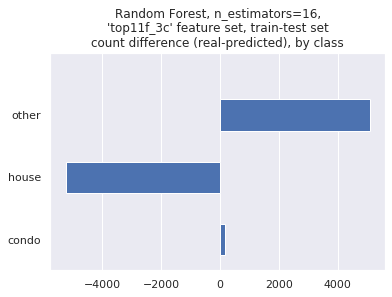

In [65]:
plot_pred_dif(s, 'lucr_e', predict_col_name, model_name=model_name, feat_set_name=feat_set_name, 
              set_name='train-test set', labels=le.classes_)

17,263 misclassified entries in the subset, or 2.02% of the total 216,155.


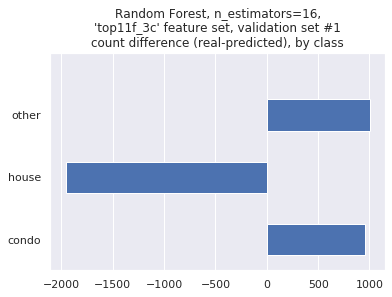

In [66]:
plot_pred_dif(s_val1, 'lucr_e', predict_col_name, model_name=model_name, feat_set_name=feat_set_name, 
              set_name='validation set #1', labels=le.classes_)

34,188 misclassified entries in the subset, or 4.00% of the total 244,425.


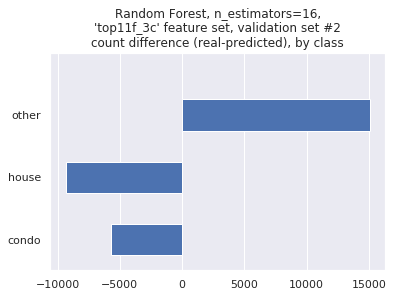

In [67]:
plot_pred_dif(s_val2, 'lucr_e', predict_col_name, model_name=model_name, feat_set_name=feat_set_name, 
              set_name='validation set #2', labels=le.classes_)

## Confusion matrix